# Creative Gaming: Propensity-to-Buy Modeling

In [1]:
import pandas as pd
import pyrsm as rsm
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestClassifier

In [2]:
## loading the data - this dataset must NOT be changed
cg_organic = pd.read_parquet("data/cg_organic.parquet")
rsm.md("data/cg_organic_description.md")

## Creative gaming

Game telemetry dataset used for the Creative Gaming: Propensity-to-Buy Modeling case

#### Feature descriptions

* converted: Purchased the Zalon campain ("yes" or "no")
* GameLevel: Highest level of game achieved by the user
* NumGameDays: Number of days user played the game in last month (with or without network connection)
* NumGameDays4Plus: Number of days user played the game in last month with 4 or more total users (this implies using a network connection)
* NumInGameMessagesSent: Number of in-game messages sent to friends
* NumFriends: Number of friends to which the user is connected (necessary to crew together in multiplayer mode) 
* NumFriendRequestIgnored: Number of friend requests this user has not replied to since game inception
* NumSpaceHeroBadges: Number of "Space Hero" badges, the highest distinction for gameplay in Space Pirates
* AcquiredSpaceship: Flag if the user owns a spaceship, i.e., does not have to crew on another user's or NPC's space ship ("no" or "yes")
* AcquiredIonWeapon: Flag if the user owns the powerful "ion weapon" ("no" or "yes")
* TimesLostSpaceship: The number of times the user destroyed his/her spaceship during gameplay. Spaceships need to be re-acquired if destroyed.
* TimesKilled: Number of times the user was killed during gameplay
* TimesCaptain: Number of times in last month that the user played in the role of a captain
* TimesNavigator: Number of times in last month that the user played in the role of a navigator
* PurchasedCoinPackSmall: Flag if the user purchased a small pack of Zathium in last month ("no" or "yes")
* PurchasedCoinPackLarge: Flag if the user purchased a large pack of Zathium in last month ("no" or "yes")
* NumAdsClicked: Number of in-app ads the user has clicked on
* DaysUser: Number of days since user established a user ID with Creative Gaming (for Space Pirates or previous games)
* UserConsole: Flag if the user plays Creative Gaming games on a console ("no" or "yes")
* UserHasOldOS: Flag if the user has iOS version 10 or earlier ("no" or "yes")
* training: Dummy variable that splits the dataset into a training (1) and test (0) dataset


In [9]:
# load a custom python module
from utils.functions import example
example()


You just accessed a function from your first python packages!
Change the code in utils/function.py to whatever you need for this assignment
Use 'from utils import functions' to get access to your code
You can add modules to import from by adding additional .py files to the 'utils' directory
Note: If you make changes to the content of this file you will have to restart the notebook kernel to get the updates



## Part I

#### 1. What is the probability of organically converting to Zalon?

In [10]:
convert_yes = (cg_organic["converted"] == "yes").sum()
prob_convert_yes = convert_yes / cg_organic.shape[0]
prob_convert_yes

0.05753333333333333

#### 2. Generate basic summary statistics for each feature in the data. For numeric variables shown the number of observations, the number of missing values, the number of distinct values, and the mean, min, max, and standard deviation. For non-numeric variables show the number of observations, the number of missing values, the number of distinct values, the most common level, and the least common level

In [11]:
describe = cg_organic.describe(include='all')
describe.loc['num_missing'] = cg_organic.isna().sum()
describe.loc['type'] = cg_organic.dtypes
describe.loc['least'] = cg_organic.value_counts().idxmin()
new_index_order = [
    'type', 'count', 'num_missing', 'unique', 'freq', 'top', 'least',
    'min', '25%', '50%', '75%', 'max','mean', 'std'
]
describe = describe.reindex(new_index_order)
describe

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesKilled,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,training
type,category,int32,int32,int32,int32,int32,int32,int32,category,category,...,int32,int32,int32,category,category,int32,int32,category,category,int32
count,30000,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0,30000,30000,...,30000.0,30000.0,30000.0,30000,30000,30000.0,30000.0,30000,30000,30000.0
num_missing,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,...,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0.0
unique,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,...,NaN,NaN,NaN,2,2,NaN,NaN,2,2,NaN
freq,28274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21695,29439,...,NaN,NaN,NaN,19857,22061,NaN,NaN,24546,27411,NaN
top,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,no,...,NaN,NaN,NaN,no,no,NaN,NaN,yes,no,NaN
least,yes,1,1,0,0,0,0,0,no,no,...,0,5,0,yes,no,3,2984,yes,no,1
min,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,0.0,244.0,NaN,NaN,0.0
25%,NaN,4.0,6.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,4.0,2162.0,NaN,NaN,0.0
50%,NaN,7.0,13.0,0.0,26.0,0.0,16.0,5.0,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,8.0,2557.0,NaN,NaN,1.0


#### 3. Generate histograms for all numeric variables and frequency plots for non-numeric variables

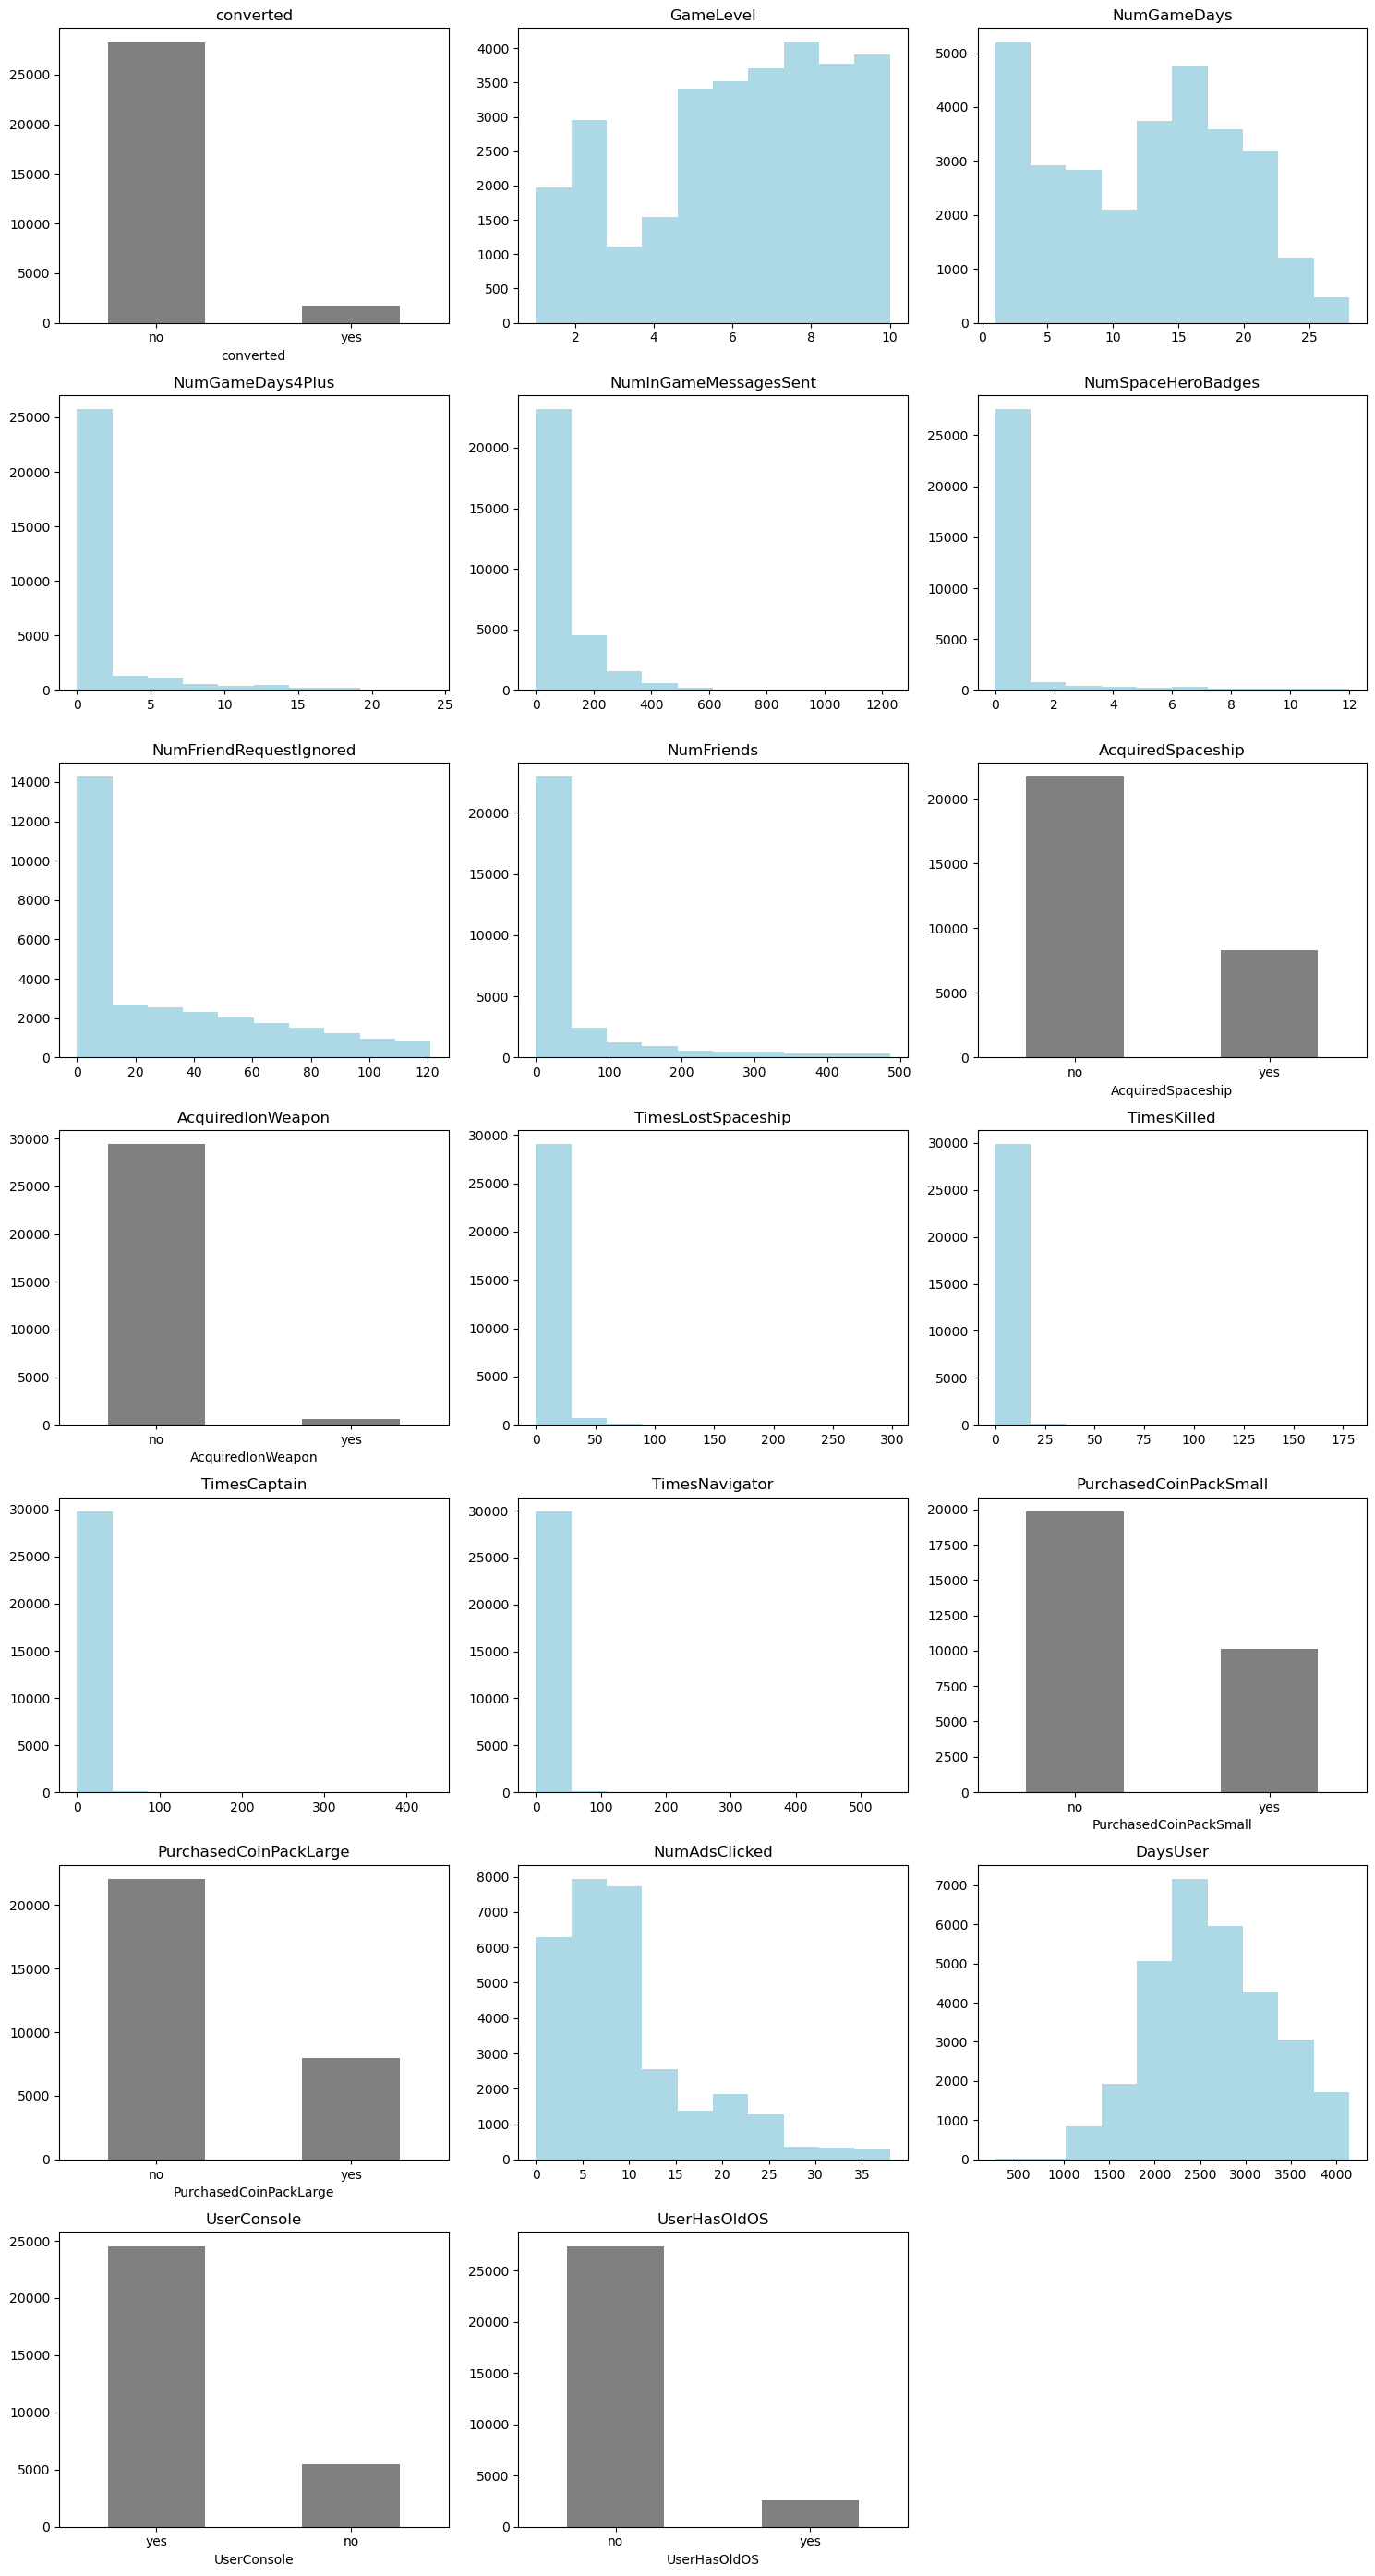

In [12]:
# Blue: Numeric
# Grey: Categorical

num_cols = 3
num_rows = math.ceil(len(cg_organic.columns.drop(['training'])) / num_cols) 
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
axes = axes.flatten() 
for i, col in enumerate(cg_organic.columns.drop(['training'])):
    ax = axes[i] 
    if cg_organic[col].dtype != 'category':
        ax.hist(cg_organic[col], color = 'lightblue')
    else:
        cg_organic[col].value_counts().plot(kind='bar', ax= ax, color='grey')
        ax.tick_params(axis='x', rotation=0)
    ax.set_title(f'{col}')
    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Part II

#### Train a logistic regression model with pyrsm or statsmodels. Use all features and use the “training” variable to set a filter (“training == 1”).

In [13]:
clf_organic = rsm.model.logistic(
    data = {"cg_organic": cg_organic[cg_organic["training"] == 1]},
    rvar = "converted",
    lev = "yes",
    evar = ["GameLevel", "NumGameDays", "NumGameDays4Plus", "NumInGameMessagesSent",
            "NumFriends", "NumFriendRequestIgnored", "NumSpaceHeroBadges",
            "AcquiredSpaceship", "AcquiredIonWeapon", "TimesLostSpaceship",
            "TimesKilled", "TimesCaptain", "TimesNavigator",
            "PurchasedCoinPackSmall", "PurchasedCoinPackLarge",
            "NumAdsClicked", "DaysUser", "UserConsole", "UserHasOldOS"
    ],
)

clf_organic.summary()

Logistic regression (GLM)
Data                 : cg_organic
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumFriends, NumFriendRequestIgnored, NumSpaceHeroBadges, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Null hyp.: There is no effect of x on converted
Alt. hyp.: There is an effect of x on converted

                                OR     OR%  coefficient  std.error  z.value p.value     
Intercept                    0.009  -99.1%        -4.75      0.190  -24.997  < .001  ***
AcquiredSpaceship[yes]       1.713   71.3%         0.54      0.072    7.486  < .001  ***
AcquiredIonWeapon[yes]       1.613   61.3%         0.48      0.203    2.353   0.019    *
PurchasedCoinPackSmall[yes]  0.912   -8.8%        -0.09      0.070   -1.316   0.18

#### 1. What are the 5 most important features? 

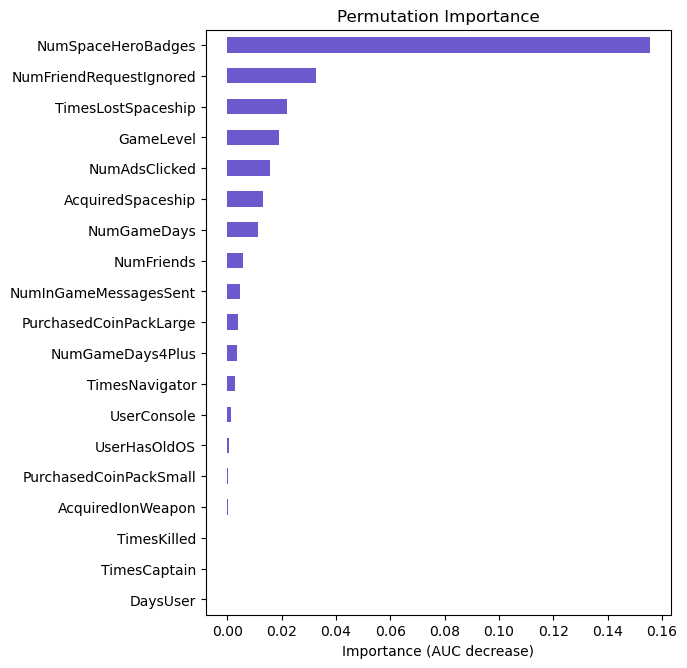

In [14]:
clf_organic.plot("vimp")

After taking the permutation importance plot and the odd ratio values into consideration, NumSpaceHeroBadges, NumFriendRequestIgnored, TimesLostSpaceship, GameLevel, and NumAdsClicked are the five most important features.

#### 2. Generate prediction plots for each of these 5 features and summarize your findings

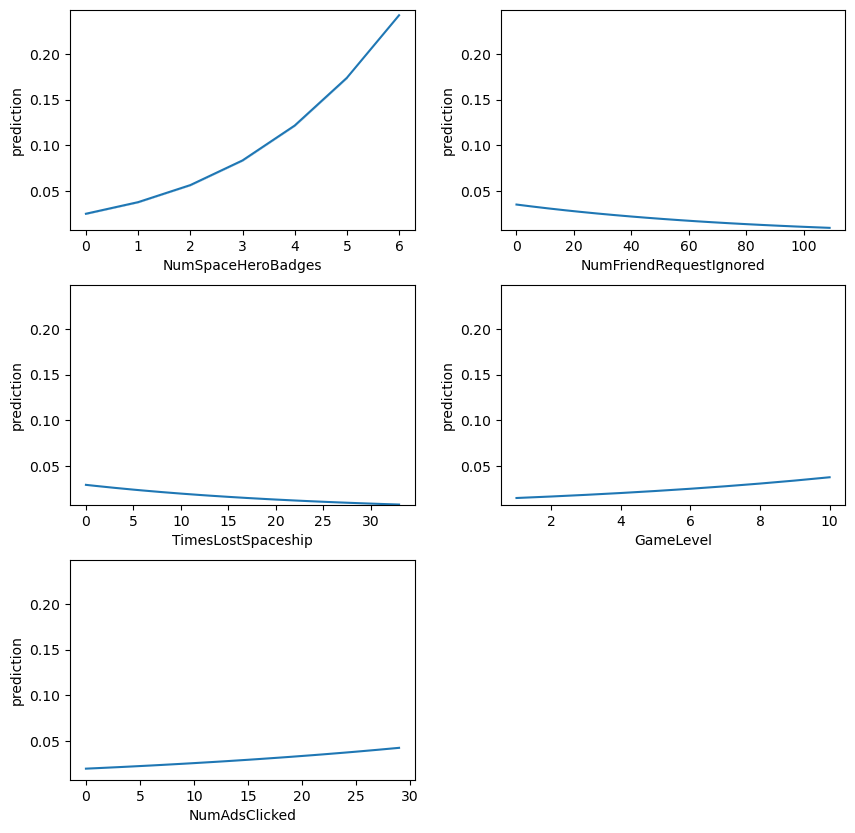

In [15]:
clf_organic.plot("pred", incl=["NumSpaceHeroBadges", "NumFriendRequestIgnored", "TimesLostSpaceship", "GameLevel", "NumAdsClicked"])

- NumSpaceHeroBadges: As the number of Space Hero badges increases, the predicted probability of buying Zalon rises, keeping all other factors constant.
- NumFriendRequestIgnored: The more friend requests a user ignores, the more the model’s predicted purchase probability declines, keeping all other factors constant.
- TimesLostSpaceship: Losing one’s spaceship more often corresponds to a slight decrease in predicted Zalon purchases, keeping all other factors constant.
- GameLevel: Higher game levels are linked to a modest but consistent increase in the likelihood of conversion, keeping all other factors constant.
- NumAdsClicked: Clicking more ads shows a clear positive trend in the model’s predicted probability of buying Zalon, keeping all other factors constant.

#### 3. Create a new variable “pred_logit” with predictions from the logistic regression model for all rows in the data

In [ ]:
# cg_organic["pred_logit"] = clf_organic.predict(data = cg_organic)["prediction"]
# cg_organic.head()

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,training,pred_logit
0,no,10,11,0,355,0,8,3,yes,no,...,5,0,no,no,4,2953,yes,yes,1,0.073430
1,no,6,7,1,30,0,0,0,yes,no,...,0,0,no,yes,8,2343,yes,no,1,0.056571
2,no,8,2,0,69,0,111,13,no,no,...,0,0,yes,no,11,2374,yes,no,1,0.008457
3,no,5,3,0,40,0,33,1,no,no,...,2,0,no,no,3,2708,yes,no,1,0.014371
4,no,6,15,0,5,0,62,0,no,no,...,0,0,no,no,11,2101,yes,yes,0,0.016892


#### 4. Plot gains curves for both the training and test set using the “pred_logit” variable

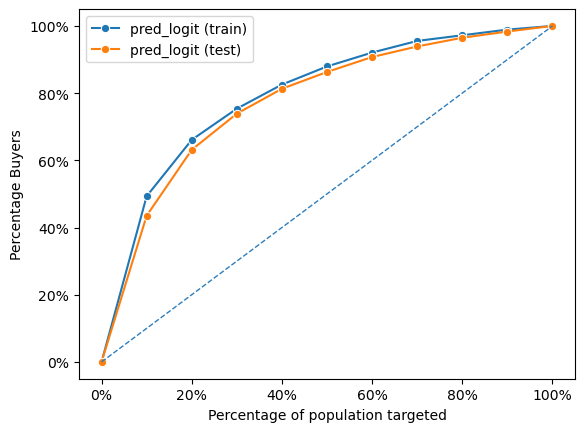

In [17]:
dct = {"train": cg_organic[cg_organic.training== 1], "test": cg_organic[cg_organic.training == 0]}
fig = rsm.gains_plot(dct, "converted", "yes", "pred_logit")

#### 5. Report the AUC of the model in both the training and test set

In [18]:
cg_organic_train = cg_organic[cg_organic.training == 1]
cg_organic_test  = cg_organic[cg_organic.training == 0]

In [19]:
# Compute training AUC
train_auc = rsm.auc(
    cg_organic_train["converted"],   
    cg_organic_train["pred_logit"],  
    "yes"                            
)

# Compute test AUC
test_auc = rsm.auc(
    cg_organic_test["converted"],
    cg_organic_test["pred_logit"],
    "yes"
)

print("Train AUC:", train_auc)
print("Test AUC:", test_auc)

Train AUC: 0.8196839375160323
Test AUC: 0.8031498993082917


## Part III

In [20]:
# Group 1
cg_organic_control = pd.read_parquet("data/cg_organic_control.parquet")
cg_organic_control.head()

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,TimesLostSpaceship,TimesKilled,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS
0,no,7,18,0,124,0,81,0,yes,no,8,0,0,4,no,yes,3,2101,no,no
1,no,10,3,2,60,0,18,479,no,no,10,7,0,0,yes,no,7,1644,yes,no
2,no,2,1,0,0,0,0,0,no,no,0,0,0,2,no,no,8,3197,yes,yes
3,no,2,11,1,125,0,73,217,no,no,0,0,0,0,yes,no,6,913,no,no
4,no,8,15,0,0,0,6,51,yes,no,0,0,2,1,yes,no,21,2009,yes,no


In [21]:
# Group 2 & 3
cg_ad_treatment= pd.read_parquet("data/cg_ad_treatment.parquet")
cg_ad_treatment.head()

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesKilled,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,rnd_30k
0,no,6,16,0,0,0,0,0,yes,no,...,0,0,0,no,no,11,1827,no,no,0
1,no,2,8,0,0,0,5,4,no,no,...,0,8,0,yes,no,3,1889,no,yes,1
2,no,6,1,0,0,0,0,0,no,no,...,0,0,0,no,yes,2,1948,yes,no,0
3,yes,7,16,0,102,1,0,194,no,no,...,0,0,0,yes,yes,21,3409,yes,yes,0
4,no,10,1,1,233,0,23,0,no,no,...,0,5,0,no,yes,4,2922,yes,no,0


#### 1. Calculate the response rate and profit of group 1. 

In [22]:
convert_yes = (cg_organic_control["converted"] == "yes").sum()
response_rate = convert_yes / cg_organic_control.shape[0]
profit = convert_yes * 14.99
print("Response Rate:", response_rate)
print("Profit:", profit)

Response Rate: 0.05686666666666667
Profit: 25572.94


#### 2. Calculate the response rate and profit of group 2. Set a filter “rnd_30k == 1” to select the 30,000 customers from the 150,000 rows in “cg_ad_treatment”. 

In [23]:
group2 = cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 1]
n_total = group2.shape[0]
convert_yes = (group2["converted"] == "yes").sum()

response_rate = convert_yes / n_total
revenue = convert_yes * 14.99
ad_cost = n_total * 1.5
profit = revenue - ad_cost

print("Response Rate:", response_rate)
print("Profit:", profit)

Response Rate: 0.13043333333333335
Profit: 13655.870000000003


#### 3. Calculate the response rate and profit of group 3.
a.  Use the logistic regression model you trained in Part II to predict the probability of purchasing the Zalon campaign (i.e., score) all 150,000 gamers in the “cg_ad_treatment”.   


In [24]:
cg_ad_treatment['pred_logit'] = clf_organic.predict(data = cg_ad_treatment)['prediction']
cg_ad_treatment.head()

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,rnd_30k,pred_logit
0,no,6,16,0,0,0,0,0,yes,no,...,0,0,no,no,11,1827,no,no,0,0.058321
1,no,2,8,0,0,0,5,4,no,no,...,8,0,yes,no,3,1889,no,yes,1,0.010403
2,no,6,1,0,0,0,0,0,no,no,...,0,0,no,yes,2,1948,yes,no,0,0.025690
3,yes,7,16,0,102,1,0,194,no,no,...,0,0,yes,yes,21,3409,yes,yes,0,0.122049
4,no,10,1,1,233,0,23,0,no,no,...,5,0,no,yes,4,2922,yes,no,0,0.039185


b.  Select the 30,000 customers with best predictions (scores) that are not part 
of group 2. Use only these 30,000 to compute conversion rates and profits 
of group 3. 

In [25]:
group3 = cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 0].copy()
group3 = group3.sort_values("pred_logit", ascending=False)
group3_best = group3.head(30000)

In [26]:
n_total = group3_best.shape[0]
convert_yes = (group3_best["converted"] == "yes").sum()
response_rate = convert_yes / n_total

revenue = convert_yes * 14.99
ad_cost = n_total * 1.50
profit = revenue - ad_cost

print("Response Rate:", response_rate)
print("Profit:", profit)

Response Rate: 0.21506666666666666
Profit: 51715.479999999996


#### 4. Answer Mi Haruki’s question: “Please report back to me how well the ads are working in terms of conversion rates and profits and by how much the model improves these metrics, all based on targeting 30,000 customers.”

- Group 2 increase conversion rate substantially (5.69% → 13.04%), but profit drops below the no‐ad group because ad costs outweigh the incremental revenue.
- Group 3 raises conversion to over 21% and increases profit to $51.7 k, far exceeding both Group 1 and Group 2.
- Thus, the ads do work at generating more conversions, but a predictive model is critical to ensure the profit more than covers the ad costs.

#### 5. Plot the gains curve for all customers that are not in group 2 (i.e., rnd_30k == 0). Also report the AUC of the for this set of customers. Compare the gains curve and AUC to the ones you calculated in Part II.4 and II.5. Why are they different?

In [27]:
not_group2 = cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 0]

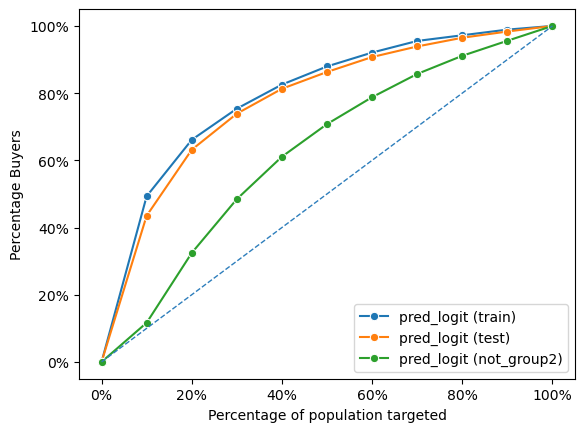

In [28]:
# Gain Curve
dct = {"train": cg_organic[cg_organic.training== 1], "test": cg_organic[cg_organic.training == 0], "not_group2": not_group2}
fig = rsm.gains_plot(dct, "converted", "yes", "pred_logit")    

In [29]:
# AUC
actual = not_group2["converted"]    
pred   = not_group2["pred_logit"]   
auc = rsm.auc(actual, pred, "yes")
print("AUC:", auc)

AUC: 0.6444723410842776


They differ because we are applying the very same model to a different population which is the users in not_group2 rather than the original training/test splits. Even though the model and features are the same, not_group2 can have different user behaviors, different conversion rates, or different feature distributions than the dataset used in Part II. Whenever the underlying population differs, the gains curve and AUC naturally shift.

#### 6. Why would CG have collecting data for group 1 (cg_organic_control) given that they already had data on organic conversions from the cg_organic data?

Creative Gaming needed a true concurrent control for the experiment which is a fresh group of gamers not shown ads in the same time period as the treatment group. Using the older organic data from cg_organic would not have been a valid baseline, because those conversions happened under different circumstances, at a different time, and possibly with different game or market conditions. By tracking a new control group in parallel with the ad‐exposed group, CG can be confident that any difference in conversions is actually due to the ads, rather than other changes over time.

## Part IV

#### 1. Retrain the logistic regression model from Part II on the random sample of 30K customers in “cg_ad_treatment” and generate predictions for all 150,000 customers. Label this retrained model “clf_ad” and assign the predictions to a new variable “pred_logit_ad”. Use pyrsm or statsmodels for estimation.

In [30]:
clf_ad= rsm.model.logistic(
    data = {"cg_ad_treatment": cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 1]},
    rvar = "converted",
    lev = "yes",
    evar = ["GameLevel", "NumGameDays", "NumGameDays4Plus", "NumInGameMessagesSent",
            "NumFriends", "NumFriendRequestIgnored", "NumSpaceHeroBadges",
            "AcquiredSpaceship", "AcquiredIonWeapon", "TimesLostSpaceship",
            "TimesKilled", "TimesCaptain", "TimesNavigator",
            "PurchasedCoinPackSmall", "PurchasedCoinPackLarge",
            "NumAdsClicked", "DaysUser", "UserConsole", "UserHasOldOS"
    ],
)

clf_ad.summary()

Logistic regression (GLM)
Data                 : cg_ad_treatment
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumFriends, NumFriendRequestIgnored, NumSpaceHeroBadges, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Null hyp.: There is no effect of x on converted
Alt. hyp.: There is an effect of x on converted

                                OR     OR%  coefficient  std.error  z.value p.value     
Intercept                    0.028  -97.2%        -3.57      0.101  -35.155  < .001  ***
AcquiredSpaceship[yes]       1.092    9.2%         0.09      0.041    2.143   0.032    *
AcquiredIonWeapon[yes]       0.879  -12.1%        -0.13      0.139   -0.929   0.353     
PurchasedCoinPackSmall[yes]  1.036    3.6%         0.04      0.038    0.924  

In [31]:
cg_ad_treatment['pred_logit_ad'] = clf_ad.predict(data = cg_ad_treatment)['prediction']
cg_ad_treatment.head()

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,rnd_30k,pred_logit,pred_logit_ad
0,no,6,16,0,0,0,0,0,yes,no,...,0,no,no,11,1827,no,no,0,0.058321,0.130246
1,no,2,8,0,0,0,5,4,no,no,...,0,yes,no,3,1889,no,yes,1,0.010403,0.041218
2,no,6,1,0,0,0,0,0,no,no,...,0,no,yes,2,1948,yes,no,0,0.025690,0.052002
3,yes,7,16,0,102,1,0,194,no,no,...,0,yes,yes,21,3409,yes,yes,0,0.122049,0.329918
4,no,10,1,1,233,0,23,0,no,no,...,0,no,yes,4,2922,yes,no,0,0.039185,0.074874


#### 2. Compare the performance of the original “organic” model from Part II and the new “ad” model across the 120,000K customers that are not in group 2. Use gains curves and AUC to make the comparison. What do you find?

Gains Curve

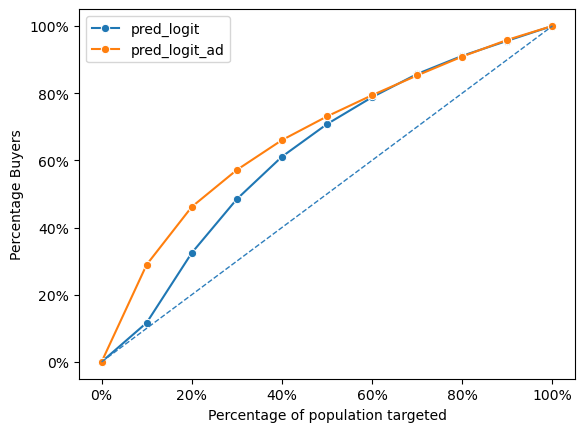

In [32]:
dct = cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 0]
fig = rsm.gains_plot(dct, "converted", "yes", ["pred_logit", "pred_logit_ad"])    

AUC

In [33]:
not_group2 = cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 0]

In [34]:
# Organic model
actual = not_group2["converted"]    
pred   = not_group2["pred_logit"]   
auc = rsm.auc(actual, pred, "yes")
print("AUC:", auc)

# Ad model
actual = not_group2["converted"]    
pred   = not_group2["pred_logit_ad"]   
auc = rsm.auc(actual, pred, "yes")
print("AUC:", auc)

AUC: 0.6444723410842776
AUC: 0.7030674399706048


Comparing to the original organic model, the new ad model has a better performance. The new ad model can better identify targeted customers.

#### 3. Calculate the profit improvement of using the “ad” model instead of the “organic” model to target the best 30,000 customers in the “cg_ad_treatment” data that are not in “rnd_30k == 1”.

In [35]:
# Organic Model
org_top30k = (
    not_group2
    .sort_values("pred_logit", ascending=False)
    .head(30_000)
)

converted_org = (org_top30k["converted"] == "yes").sum()

revenue_org = converted_org * 14.99
cost_org    = 30_000 * 1.50
profit_org  = revenue_org - cost_org

# ad Model
ad_top30k = (
    not_group2
    .sort_values("pred_logit_ad", ascending=False)
    .head(30_000)
)

converted_ad = (ad_top30k["converted"] == "yes").sum()

revenue_ad = converted_ad * 14.99
cost_ad    = 30_000 * 1.50
profit_ad  = revenue_ad - cost_ad

profit_improvement = profit_ad - profit_org
print("Profit Improvement:", profit_improvement)

Profit Improvement: 26457.350000000006


#### 4. Compare the permutation importance plot of the “organic” and the “ad” model. Explain why you think the plots differ.

Organic Model

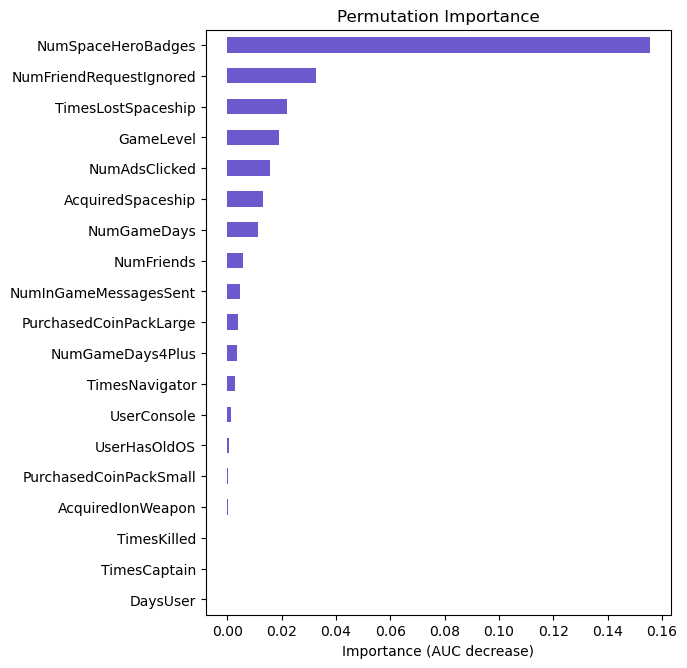

In [36]:
clf_organic.plot("vimp")

ad Model

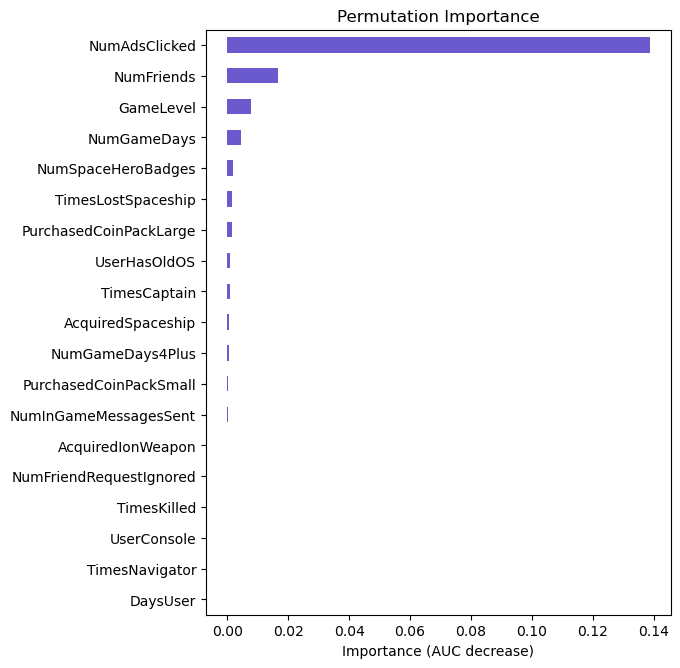

In [37]:
clf_ad.plot("vimp")

Because each model was trained on different data (the “organic” model on the older, no‐ad dataset vs. the “ad” model on the ad‐exposed random sample), they learn different signals about which features best predict Zalon purchase. Since the populations, user behaviors, and time frames differ, the models emphasize different predictive drivers, and thus produce different permutation importance rankings.

## Part V

#### 1. Train and tune a neural network on the random sample of customers who were exposed to the ad campaign (i.e., rnd_30k == 1). Select two hyper parameters for your grid to tune on. Use both pyrsm and sklearn for estimation and check the similarity of your results 

##### 1. pyrsm

In [38]:
evar = cg_ad_treatment.drop(columns = ['converted','rnd_30k', 'pred_logit', 'pred_logit_ad']).columns

Baseline

In [39]:
clf_nnc = rsm.model.mlp(
                  {'cg_ad_treatment': cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 1]}, 
                   rvar = 'converted', 
                   lev = 'yes',
                   evar = evar,
                   hidden_layer_sizes = (1,),
                   mod_type = 'classification'
                   )

clf_nnc.summary()

Multi-layer Perceptron (NN)
Data                 : cg_ad_treatment
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Model type           : classification
Nr. of features      : (19, 19)
Nr. of weights       : 20
Nr. of observations  : 30,000
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.706

Raw data             :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFrie

Tuning

In [40]:
hls = [(5, 5), (10,), (8,8)]
alpha = [0.0001, 0.001, 0.01]
param_grid = {"hidden_layer_sizes": hls, "alpha": alpha}
scoring = {"AUC": "roc_auc"}
clf_nnc_cv = GridSearchCV(
    clf_nnc.fitted, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
)

In [41]:
clf_nnc_cv.fit(clf_nnc.data_onehot, clf_nnc.data.converted)
pd.DataFrame(clf_nnc_cv.cv_results_).iloc[:, 5:].sort_values("rank_test_AUC")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,param_hidden_layer_sizes,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
6,"(5, 5)","{'alpha': 0.01, 'hidden_layer_sizes': (5, 5)}",0.763353,0.769055,0.790151,0.776235,0.772142,0.774187,0.009022,1
0,"(5, 5)","{'alpha': 0.0001, 'hidden_layer_sizes': (5, 5)}",0.768350,0.771662,0.778648,0.779268,0.767954,0.773176,0.004897,2
1,"(10,)","{'alpha': 0.0001, 'hidden_layer_sizes': (10,)}",0.752680,0.771145,0.774929,0.774208,0.771836,0.768960,0.008261,3
4,"(10,)","{'alpha': 0.001, 'hidden_layer_sizes': (10,)}",0.754745,0.772207,0.778765,0.770464,0.768504,0.768937,0.007890,4
3,"(5, 5)","{'alpha': 0.001, 'hidden_layer_sizes': (5, 5)}",0.763707,0.760977,0.787135,0.762790,0.761465,0.767215,0.010007,5
7,"(10,)","{'alpha': 0.01, 'hidden_layer_sizes': (10,)}",0.753193,0.767223,0.774987,0.763552,0.765640,0.764919,0.007022,6
5,"(8, 8)","{'alpha': 0.001, 'hidden_layer_sizes': (8, 8)}",0.740285,0.764448,0.768761,0.771173,0.757341,0.760402,0.011102,7
8,"(8, 8)","{'alpha': 0.01, 'hidden_layer_sizes': (8, 8)}",0.748219,0.756583,0.768370,0.767940,0.758660,0.759955,0.007554,8
2,"(8, 8)","{'alpha': 0.0001, 'hidden_layer_sizes': (8, 8)}",0.744559,0.753218,0.771860,0.770578,0.755893,0.759222,0.010496,9


Final Model

In [42]:
clf_nnc1 = rsm.model.mlp(
                  {'cg_ad_treatment': cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 1]}, 
                   rvar = 'converted', 
                   lev = 'yes',
                   evar = evar,
                   hidden_layer_sizes = (5,5),
                   alpha=0.001, 
                   mod_type = 'classification'
                   )

clf_nnc1.summary()

Multi-layer Perceptron (NN)
Data                 : cg_ad_treatment
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumSpaceHeroBadges, NumFriendRequestIgnored, NumFriends, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
Model type           : classification
Nr. of features      : (19, 19)
Nr. of weights       : 125
Nr. of observations  : 30,000
Hidden_layer_sizes   : (5, 5)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.001
Batch size           : auto
Learning rate        : 0.001
Maximum iterations   : 1000000
random_state         : 1234
AUC                  : 0.793

Raw data             :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumSpaceHeroBadges  NumFriendRequestIgnored  NumFr

##### 2. sklearn

In [43]:
df_ad_30k = cg_ad_treatment.loc[cg_ad_treatment["rnd_30k"] == 1].copy()
y = (df_ad_30k["converted"] == "yes").astype(int)
X = df_ad_30k[evar]

In [44]:
binary_flags = ["AcquiredSpaceship", "AcquiredIonWeapon", 
                "PurchasedCoinPackSmall", "PurchasedCoinPackLarge",
                "UserConsole", "UserHasOldOS"]

for col in binary_flags:
    X[col] = np.where(X[col] == "yes", 1, 0)

/tmp/ipykernel_99640/718985613.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = np.where(X[col] == "yes", 1, 0)


In [45]:
mlp = MLPClassifier(
    solver="adam",       
    max_iter=200,       
    random_state=42
)

param_grid = {
    "hidden_layer_sizes": [(5,5), (10,), (8,8)],  
    "alpha": [0.0001, 0.001, 0.01]
}

In [46]:
scorer = make_scorer(roc_auc_score, needs_proba=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_cv = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring=scorer,
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_cv.fit(X, y)

print("Best params:", grid_cv.best_params_)
print("Best AUC:", grid_cv.best_score_)

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'alpha': 0.0001, 'hidden_layer_sizes': (10,)}
Best AUC: 0.7143830919371997


Despite using the same hyperparameter grid, pyrsm and sklearn yield different results because we believe that they have slightly different defaults and sometimes different data preprocessing steps behind the scenes.

#### 2. Compare the performance of the neural network “ad” model and the logistic regression “ad” model from Part IV using data from the 120,000K customers that are not in group 2. Use gains curves and AUC for the comparison. What do you find? 

In [47]:
cg_ad_treatment["pred_nn"] = clf_nnc1.predict(data = cg_ad_treatment)["prediction"]
cg_ad_treatment.head()

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,rnd_30k,pred_logit,pred_logit_ad,pred_nn
0,no,6,16,0,0,0,0,0,yes,no,...,no,no,11,1827,no,no,0,0.058321,0.130246,0.013344
1,no,2,8,0,0,0,5,4,no,no,...,yes,no,3,1889,no,yes,1,0.010403,0.041218,0.054604
2,no,6,1,0,0,0,0,0,no,no,...,no,yes,2,1948,yes,no,0,0.025690,0.052002,0.035387
3,yes,7,16,0,102,1,0,194,no,no,...,yes,yes,21,3409,yes,yes,0,0.122049,0.329918,0.472436
4,no,10,1,1,233,0,23,0,no,no,...,no,yes,4,2922,yes,no,0,0.039185,0.074874,0.025771


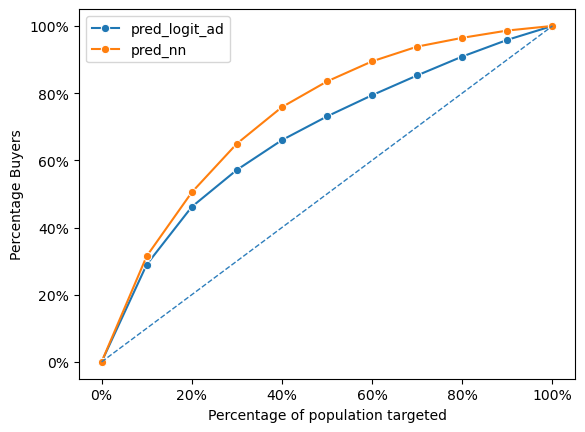

In [48]:
fig = rsm.gains_plot(
    cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 0],
    rvar="converted",    
    lev="yes",        
    pred=["pred_logit_ad", "pred_nn"]  
)

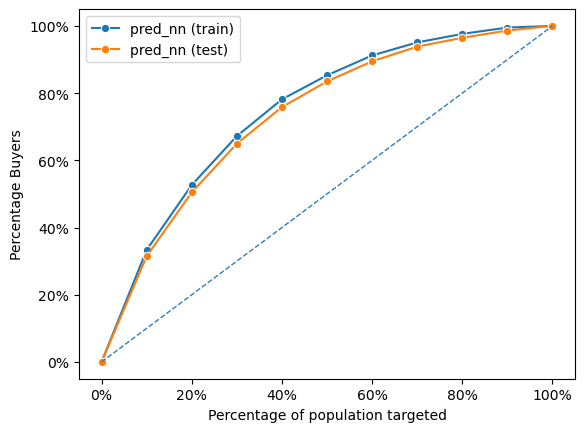

In [49]:
# Overfitting Check
fig = rsm.gains_plot(
    {"train": cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 1], "test": cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 0]},
    rvar="converted",    
    lev="yes",        
    pred="pred_nn"
)

In [50]:
not_group2 = cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 0]

# Organic model
actual = not_group2["converted"]    
pred   = not_group2["pred_logit_ad"]   
auc = rsm.auc(actual, pred, "yes")
print("AUC:", auc)

# Ad model
actual = not_group2["converted"]    
pred   = not_group2["pred_nn"]   
auc = rsm.auc(actual, pred, "yes")
print("AUC:", auc)

AUC: 0.7030674399706048
AUC: 0.7744232856957103


#### 3. Calculate the profit improvement of using the neural network “ad” model and the logistic regression “ad” model to target the best 30,000 customers out of the 120,000K customers that are not in group 2.

In [51]:
# Logistic regression ad
logit_ad = not_group2.sort_values("pred_logit_ad", ascending=False).head(30000)
conversions_logit = (logit_ad["converted"] == "yes").sum()
revenue_logit = conversions_logit * 14.99
cost_logit = 30_000 * 1.50
profit_logit = revenue_logit - cost_logit

# nn ad
nn_ad = not_group2.sort_values("pred_nn", ascending=False).head(30000)
conversions_nn = (nn_ad["converted"] == "yes").sum()
revenue_nn = conversions_nn * 14.99
cost_nn = 30_000 * 1.50
profit_nn = revenue_nn - cost_nn

profit_improvement = profit_nn - profit_logit

print(f"Logistic AD model profit:  ${profit_logit:,.2f}")
print(f"Neural Net AD model profit: ${profit_nn:,.2f}")
print(f"Profit Improvement:         ${profit_improvement:,.2f}")

Logistic AD model profit:  $78,172.83
Neural Net AD model profit: $92,188.48
Profit Improvement:         $14,015.65


#### 4. Train and tune a random forest on the random sample of customers who were exposed to the ad campaign (i.e., rnd_30k == 1). Select two hyper parameters for your grid to tune on, one of which should be “max_features”. Choose at least 5 different values for “max_features” for your grid.

Baseline

In [52]:
clf_rf1 = rsm.model.rforest(
    {'cg_ad_treatment': cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 1]},    
    rvar="converted",     
    lev="yes",
    evar= ["GameLevel", "NumGameDays", "NumGameDays4Plus",
    "NumInGameMessagesSent", "NumFriends", "NumFriendRequestIgnored",
    "NumSpaceHeroBadges", "AcquiredSpaceship", "AcquiredIonWeapon",
    "TimesLostSpaceship", "TimesKilled", "TimesCaptain", "TimesNavigator",
    "PurchasedCoinPackSmall", "PurchasedCoinPackLarge", "NumAdsClicked",
    "DaysUser", "UserConsole", "UserHasOldOS"],
    max_features=2,
    n_estimators=100,
)
clf_rf1.summary()

Random Forest
Data                 : cg_ad_treatment
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumFriends, NumFriendRequestIgnored, NumSpaceHeroBadges, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
OOB                  : True
Model type           : classification
Nr. of features      : (19, 19)
Nr. of observations  : 30,000
max_features         : 2 (2)
n_estimators         : 100
min_samples_leaf     : 1
random_state         : 1234
AUC                  : 0.758

Estimation data      :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumFriends  NumFriendRequestIgnored  NumSpaceHeroBadges  TimesLostSpaceship  TimesKilled  TimesCaptain  TimesNavigator  NumAdsClicked  DaysUser  AcquiredSpaceship_yes  AcquiredIonWeapon_

Tuning

In [53]:
evar2 = pd.DataFrame()
for col in cg_ad_treatment.drop(columns = ['converted', 'pred_logit', 'pred_logit_ad', 'pred_nn']).columns:
    if cg_ad_treatment[col].dtypes == 'category':
        evar2[col] = rsm.ifelse(cg_ad_treatment[col]=='yes', 1, 0)
    else:
        evar2[col] = cg_ad_treatment[col]

In [54]:
clf_rf = RandomForestClassifier(n_estimators=100, max_features=range(3,8), oob_score=True, random_state=42, class_weight= 'balanced')
scoring = {"AUC": "roc_auc"}
param_grid = {
    "n_estimators": list(range(200, 401, 100)),
    "max_features": range(2, 6)
    }
clf_rf_cv = GridSearchCV(
    clf_rf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(evar2.query('rnd_30k==1'), cg_ad_treatment.query('rnd_30k==1')["converted"]=='yes')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/conda/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [55]:
clf_rf_cv.best_params_

{'max_features': 4, 'n_estimators': 400}

In [56]:
clf_rf_cv.best_score_

0.7791840815210227

Final Model

In [57]:
clf_rf2 = rsm.model.rforest(
    {'cg_ad_treatment': cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 1]},    
    rvar="converted",     
    lev="yes",
    evar= ["GameLevel", "NumGameDays", "NumGameDays4Plus",
    "NumInGameMessagesSent", "NumFriends", "NumFriendRequestIgnored",
    "NumSpaceHeroBadges", "AcquiredSpaceship", "AcquiredIonWeapon",
    "TimesLostSpaceship", "TimesKilled", "TimesCaptain", "TimesNavigator",
    "PurchasedCoinPackSmall", "PurchasedCoinPackLarge", "NumAdsClicked",
    "DaysUser", "UserConsole", "UserHasOldOS"],
    **clf_rf_cv.best_params_
)
clf_rf2.summary()

Random Forest
Data                 : cg_ad_treatment
Response variable    : converted
Level                : yes
Explanatory variables: GameLevel, NumGameDays, NumGameDays4Plus, NumInGameMessagesSent, NumFriends, NumFriendRequestIgnored, NumSpaceHeroBadges, AcquiredSpaceship, AcquiredIonWeapon, TimesLostSpaceship, TimesKilled, TimesCaptain, TimesNavigator, PurchasedCoinPackSmall, PurchasedCoinPackLarge, NumAdsClicked, DaysUser, UserConsole, UserHasOldOS
OOB                  : True
Model type           : classification
Nr. of features      : (19, 19)
Nr. of observations  : 30,000
max_features         : 4 (4)
n_estimators         : 400
min_samples_leaf     : 1
random_state         : 1234
AUC                  : 0.776

Estimation data      :
 GameLevel  NumGameDays  NumGameDays4Plus  NumInGameMessagesSent  NumFriends  NumFriendRequestIgnored  NumSpaceHeroBadges  TimesLostSpaceship  TimesKilled  TimesCaptain  TimesNavigator  NumAdsClicked  DaysUser  AcquiredSpaceship_yes  AcquiredIonWeapon_

#### 5. Compare the performance of the random forest “ad” model and the logistic regression “ad” model from Part IV using data from the 120,000K customers that are not in group 2. Use gains curves and AUC for the comparison. What do you find?

In [58]:
cg_ad_treatment["pred_rf"] = clf_rf2.predict(cg_ad_treatment)["prediction"]
cg_ad_treatment.head()

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,rnd_30k,pred_logit,pred_logit_ad,pred_nn,pred_rf
0,no,6,16,0,0,0,0,0,yes,no,...,no,11,1827,no,no,0,0.058321,0.130246,0.013344,0.0100
1,no,2,8,0,0,0,5,4,no,no,...,no,3,1889,no,yes,1,0.010403,0.041218,0.054604,0.0425
2,no,6,1,0,0,0,0,0,no,no,...,yes,2,1948,yes,no,0,0.025690,0.052002,0.035387,0.0625
3,yes,7,16,0,102,1,0,194,no,no,...,yes,21,3409,yes,yes,0,0.122049,0.329918,0.472436,0.3200
4,no,10,1,1,233,0,23,0,no,no,...,yes,4,2922,yes,no,0,0.039185,0.074874,0.025771,0.0725


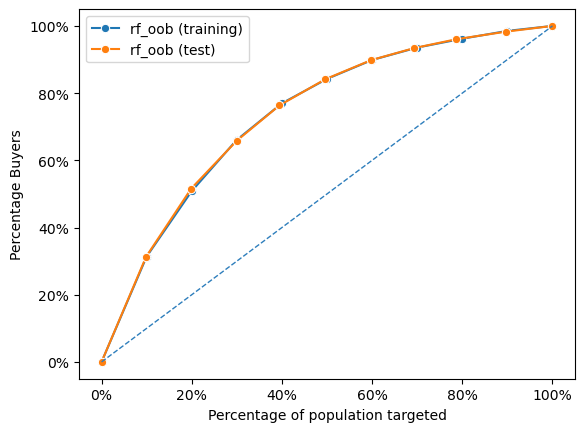

In [59]:
##checking overfitting
# compare gains for RandomForest (OOB) in training vs test with OOB
cg_ad_treatment["rf_oob"] = cg_ad_treatment.pred_rf
cg_ad_treatment.loc[cg_ad_treatment.rnd_30k==1, "rf_oob"] = clf_rf_cv.best_estimator_.oob_decision_function_[:, 1]
dct = {
    "training": cg_ad_treatment[cg_ad_treatment.rnd_30k == 1],
    "test": cg_ad_treatment[cg_ad_treatment.rnd_30k == 0],
}
fig = rsm.gains_plot(dct, "converted", 'yes', "rf_oob")

Gains Curve

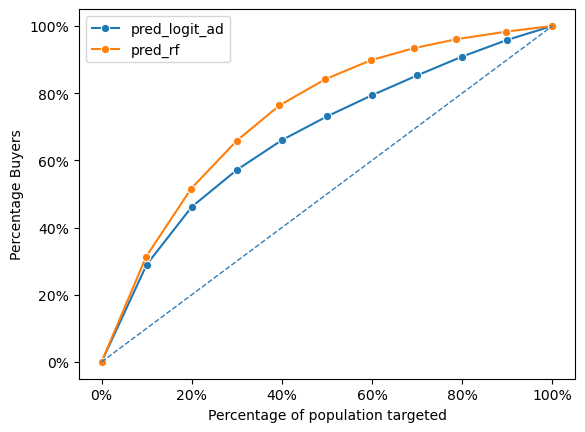

In [60]:
fig = rsm.gains_plot(
    cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 0],
    rvar="converted",    
    lev="yes",        
    pred=["pred_logit_ad", "pred_rf"]  
)

AUC

In [61]:
not_group2 = cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 0]

# Organic model
actual = not_group2["converted"]    
pred   = not_group2["pred_logit_ad"]   
auc = rsm.auc(actual, pred, "yes")
print("AUC:", auc)

# Ad model
actual = not_group2["converted"]    
pred   = not_group2["pred_rf"]   
auc = rsm.auc(actual, pred, "yes")
print("AUC:", auc)

AUC: 0.7030674399706048
AUC: 0.7796836959599366


The random forest model outperformed the logistic regression model in both AUC and the gain plot, demonstrating a stronger predictive ability.

#### 6. Calculate the profit improvement of using the random forest “ad” model and the logistic regression “ad” model to target the best 30,000 customers out of the 120,000K customers that are not in group 2.

In [62]:
not_group2 = cg_ad_treatment[cg_ad_treatment["rnd_30k"] == 0].copy()

# logistic ad
top30k_logit = not_group2.sort_values("pred_logit_ad", ascending=False).head(30_000)
converted_logit = (top30k_logit["converted"] == "yes").sum()
revenue_logit = converted_logit * 14.99

cost_logit = 30_000 * 1.50
profit_logit = revenue_logit - cost_logit

# rf ad
top30k_rf = not_group2.sort_values("pred_rf", ascending=False).head(30_000)
converted_rf = (top30k_rf["converted"] == "yes").sum()
revenue_rf = converted_rf * 14.99
cost_rf = 30_000 * 1.50
profit_rf = revenue_rf - cost_rf

profit_improvement = profit_rf - profit_logit

print(f"Logistic ad model profit:  ${profit_logit:,.2f}")
print(f"RF ad model profit:        ${profit_rf:,.2f}")
print(f"Profit improvement:        ${profit_improvement:,.2f}")

Logistic ad model profit:  $78,172.83
RF ad model profit:        $95,351.37
Profit improvement:        $17,178.54
